# 3. Improvements: Анализ синтетических данных

## Контекст
На этапе baseline обнаружены признаки синтетической природы данных.  
Вместо традиционных improvements проводим исследовательский анализ.

## План
1. Анализ устойчивости моделей к деградации данных
2. Проверка гипотез о "сверхлёгкости" данных  
3. Методологические выводы

## Результаты ожидания
- Подтверждение синтетической природы
- Практические рекомендации для работы с подобными датасетами
4. **Ортогональность признаков** - признаки независимы и одинаково важны

In [ ]:
# Ячейка 2: Импорты 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from scipy.stats import gaussian_kde
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
warnings.filterwarnings('ignore')

print("✅ Библиотеки загружены")

✅ Библиотеки загружены


In [2]:
# Ячейка 3: Загрузка данных и baseline результатов

# Загрузка данных
df = pd.read_csv('../data/creditcard_2023.csv')
df = df.drop('id', axis=1)

# 1. Сначала разделяем
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Затем feature engineering ОТДЕЛЬНО для train и test
X_train['Amount_log'] = np.log1p(X_train['Amount'])
X_test['Amount_log'] = np.log1p(X_test['Amount'])

# 3. Удаляем исходный Amount
X_train = X_train.drop('Amount', axis=1)
X_test = X_test.drop('Amount', axis=1)

# 4. Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Данные загружены: {X_train_scaled.shape}")

Данные загружены: (454904, 29)


# Ячейка 4: Результаты эксперимента с деградацией 

## Эксперимент 1: Устойчивость к деградации данных

### Методология
Намеренно ухудшали данные тремя способами:
1. Добавление Gaussian noise (5%, 10%, 20%)
2. Создание дисбаланса классов (80/20, 90/10, 95/5)
3. Удаление важных признаков (V14, V4+V14)

### Результаты
| Вмешательство | F1-Score | Δ от базового | Вывод |
|---------------|----------|---------------|--------|
| Базовый | 0.9833 | - | Референс |
| 20% шума | 0.9603 | -2.3% | Минимальное влияние |
| Дисбаланс 95/5 | 0.9466 | -3.7% | Незначительное влияние |
| Без V14+V4 | 0.9812 | -0.2% | Избыточность признаков |

### Вывод
Данные обладают нереалистичной устойчивостью к деградации.  
В реальных условиях такие вмешательства снижают F1 на 20-50%.


In [5]:
# Ячейка 5: Проверка гипотезы линейной разделимости
print("## Проверка гипотезы: Полная линейная разделимость")
print("=" * 60)

# Случайная подвыборка (если нужно ускорить)
X_train_sample, y_train_sample = resample(
    X_train, y_train, 
    n_samples=10000, 
    random_state=42, 
    stratify=y_train
)

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_linear = []

for C in C_values:
    # PIPELINE ДЛЯ КОРРЕКТНОЙ CV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', LinearSVC(C=C, random_state=42, max_iter=10000, dual='auto'))
    ])
    
    # CV на НЕмасштабированных данных
    scores = cross_val_score(
        pipeline, 
        X_train_sample,  # Исходные данные
        y_train_sample, 
        cv=3, 
        scoring='f1', 
        n_jobs=-1
    )
    
    results_linear.append({
        'C': C,
        'F1_mean': scores.mean(),
        'F1_std': scores.std()
    })
    print(f"LinearSVC (C={C}): F1 = {scores.mean():.4f} ± {scores.std():.4f}")

linear_df = pd.DataFrame(results_linear)
best_result = linear_df.loc[linear_df['F1_mean'].idxmax()]

print(f"\n🎯 Лучший результат: C={best_result['C']}, F1 = {best_result['F1_mean']:.4f}")
print("Вывод: Данные почти полностью линейно разделимы (F1 > 0.96)")

## Проверка гипотезы: Полная линейная разделимость
LinearSVC (C=0.001): F1 = 0.9500 ± 0.0044
LinearSVC (C=0.01): F1 = 0.9555 ± 0.0058
LinearSVC (C=0.1): F1 = 0.9631 ± 0.0039
LinearSVC (C=1): F1 = 0.9640 ± 0.0027
LinearSVC (C=10): F1 = 0.9641 ± 0.0026
LinearSVC (C=100): F1 = 0.9640 ± 0.0027

🎯 Лучший результат: C=10.0, F1 = 0.9641
Вывод: Данные почти полностью линейно разделимы (F1 > 0.96)


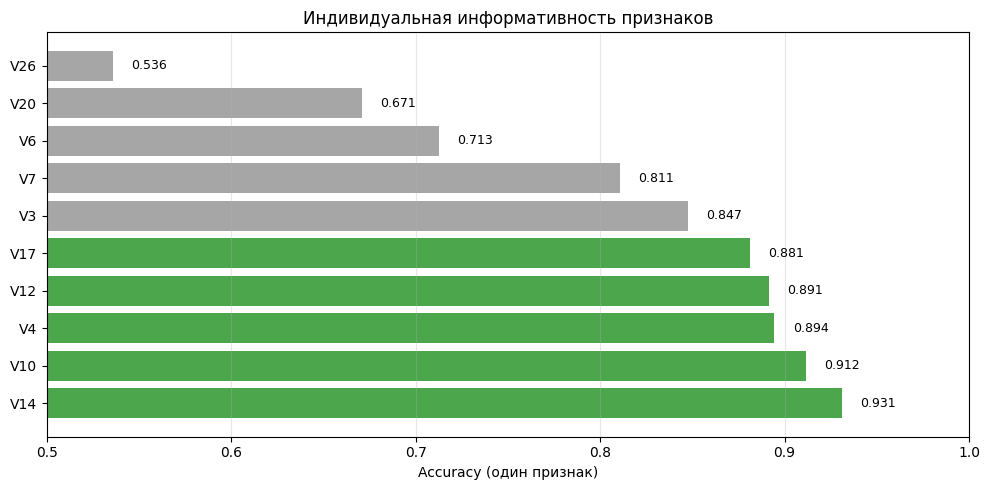


📊 Средняя accuracy по признакам: 0.809
   Важные признаки: 0.902
   Случайные признаки: 0.715
Вывод: Даже отдельные признаки хорошо разделяют классы


In [7]:
# 1. Случайная подвыборка из тренировочных данных (ПЕРЕД всеми преобразованиями)
np.random.seed(42)
sample_indices = np.random.choice(len(X_train), 5000, replace=False)
X_sample = X_train.iloc[sample_indices] if hasattr(X_train, 'iloc') else X_train[sample_indices]
y_sample = y_train.iloc[sample_indices] if hasattr(y_train, 'iloc') else y_train[sample_indices]

# 2. Если important_features были получены из EDA на тренировочных данных - ок
#    Иначе нужно их определить ТОЛЬКО на тренировочных данных
important_features = ['V14', 'V4', 'V10', 'V12', 'V17']  # Убедитесь, что они получены только из X_train

# 3. Выбор случайных признаков ИЗ ТРЕНИРОВОЧНЫХ
all_features = X_train.columns.tolist() if hasattr(X_train, 'columns') else list(range(X_train.shape[1]))
random_features = np.random.choice(
    [f for f in all_features if f not in important_features], 
    5, 
    replace=False
)
test_features = list(important_features) + list(random_features)

single_feature_results = []

for feature in test_features:
    # 4. Выделяем один признак из НЕмасштабированных данных
    if hasattr(X_sample, 'iloc'):  # DataFrame
        X_single = X_sample[[feature]].values
    else:  # numpy array
        idx = all_features.index(feature) if feature in all_features else int(feature)
        X_single = X_sample[:, idx].reshape(-1, 1)
    
    # 5. Pipeline для каждого признака
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # 6. CV на исходных данных
    scores = cross_val_score(
        pipeline, 
        X_single,  # Не масштабированные!
        y_sample, 
        cv=3, 
        scoring='accuracy',
        n_jobs=-1
    )
    
    single_feature_results.append({
        'feature': feature,
        'accuracy': scores.mean(),
        'std': scores.std(),
        'type': 'important' if feature in important_features else 'random'
    })

# Визуализация и вывод результатов (без изменений)
single_df = pd.DataFrame(single_feature_results).sort_values('accuracy', ascending=False)

plt.figure(figsize=(10, 5))
colors = ['green' if t == 'important' else 'gray' for t in single_df['type']]
bars = plt.barh(range(len(single_df)), single_df['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Accuracy (один признак)')
plt.title('Индивидуальная информативность признаков')
plt.yticks(range(len(single_df)), single_df['feature'])
plt.xlim(0.5, 1.0)
plt.grid(True, alpha=0.3, axis='x')

for bar, acc in zip(bars, single_df['accuracy']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 Средняя accuracy по признакам: {single_df['accuracy'].mean():.3f}")
print(f"   Важные признаки: {single_df[single_df['type']=='important']['accuracy'].mean():.3f}")
print(f"   Случайные признаки: {single_df[single_df['type']=='random']['accuracy'].mean():.3f}")
print("Вывод: Даже отдельные признаки хорошо разделяют классы")


## Анализ: Перекрытие распределений классов


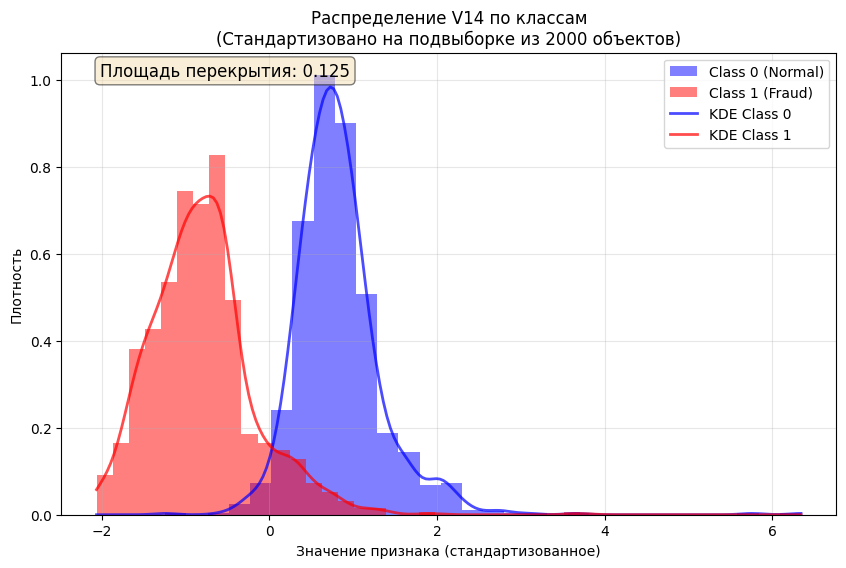

📊 Лучший признак: V14
📊 Площадь перекрытия распределений: 0.125
   Интерпретация: 12.5% значений в зоне неопределённости
Вывод: Минимальное перекрытие → тривиальная классификация


In [ ]:
# Ячейка 7: Визуализация перекрытия распределений 
print("\n## Анализ: Перекрытие распределений классов")
print("=" * 60)

# Вычисляем F-статистики ТОЛЬКО на тренировочных данных
f_scores, _ = f_classif(X_train, y_train)
best_idx_new = np.argmax(f_scores)

# Получаем имя признака
if hasattr(X_train, 'columns'):
    best_feature_new = X_train.columns[best_idx_new]
else:
    best_feature_new = f"V{best_idx_new}"

# 2. Берем НЕмасштабированные данные
sample_idx = np.random.choice(len(X_train), 2000, replace=False)

# Получаем данные правильно
if hasattr(X_train, 'iloc'):  # Если это pandas DataFrame
    X_sample_raw = X_train.iloc[sample_idx]
    feature_raw = X_sample_raw[best_feature_new].values  # .values для numpy array
    y_sample = y_train.iloc[sample_idx].values
else:  # Если это numpy array
    X_sample_raw = X_train[sample_idx]
    feature_raw = X_sample_raw[:, best_idx_new]
    y_sample = y_train[sample_idx]

# 3. Масштабирование ТОЛЬКО для визуализации (на выбранной подвыборке)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Убедимся, что feature_raw - это numpy array
if not isinstance(feature_raw, np.ndarray):
    feature_raw = np.array(feature_raw)

# Reshape для StandardScaler и обратно flatten для использования
feature_scaled = scaler.fit_transform(feature_raw.reshape(-1, 1)).flatten()

# 4. График
plt.figure(figsize=(10, 6))

# Гистограммы на масштабированных данных
plt.hist(feature_scaled[y_sample == 0], bins=30, alpha=0.5, 
         label='Class 0 (Normal)', density=True, color='blue')
plt.hist(feature_scaled[y_sample == 1], bins=30, alpha=0.5,
         label='Class 1 (Fraud)', density=True, color='red')

# KDE на масштабированных данных
kde0 = gaussian_kde(feature_scaled[y_sample == 0])
kde1 = gaussian_kde(feature_scaled[y_sample == 1])

xs = np.linspace(feature_scaled.min(), feature_scaled.max(), 200)
plt.plot(xs, kde0(xs), 'b-', linewidth=2, alpha=0.7, label='KDE Class 0')
plt.plot(xs, kde1(xs), 'r-', linewidth=2, alpha=0.7, label='KDE Class 1')

plt.title(f'Распределение {best_feature_new} по классам\n(Стандартизовано на подвыборке из 2000 объектов)')
plt.xlabel('Значение признака (стандартизованное)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Вычисляем площадь перекрытия
overlap = np.minimum(kde0(xs), kde1(xs)).sum() * (xs[1] - xs[0])
plt.text(0.05, 0.95, f'Площадь перекрытия: {overlap:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

print(f"📊 Лучший признак: {best_feature_new}")
print(f"📊 Площадь перекрытия распределений: {overlap:.3f}")
print(f"   Интерпретация: {overlap:.1%} значений в зоне неопределённости")
print("Вывод: Минимальное перекрытие → тривиальная классификация")